In [21]:
import pandas as pd
from datetime import datetime
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

# read in the data
dataset = pd.read_csv('prepared_gasoline.csv')

# read in the geo data
geo = pd.read_csv('latlongeo.csv')
geo.drop(['Unnamed: 0', 'region'], axis=1, inplace=True)

# join them -- inner drops the lat/lon nan values
dataset = dataset.merge(geo, how='inner', on=['latitude', 'longitude'])

# add global mean of gas price for each observation
global_mean = dataset.groupby('date')['e5gas'].mean()
global_df = global_mean.to_frame()
global_df.rename(columns={"e5gas": "global_mean"}, inplace=True)
dataset = dataset.merge(global_df, right_index=True, left_on='date')

# add regional mean of gas price for each observation
state_mean = dataset.groupby(['date', 'state'])['e5gas'].mean()
state_df = state_mean.to_frame()
state_df.rename(columns={"e5gas": "state_mean"}, inplace=True)
dataset = dataset.merge(state_df, right_index=True, left_on=['date', 'state'])

# one hot encode state and marke
dataset['state'] = pd.Categorical(dataset['state']).codes

In [22]:
# create index for each station, keep only stations with all 575 days
station_indices = dataset['station'].value_counts() == 575
full_series = pd.DataFrame()
full_series['T/F'] = station_indices[station_indices]
full_series['index'] = full_series.index
dataset_fullseries = dataset[dataset['station'].isin(full_series['index'])]

In [23]:
df = dataset_fullseries

In [24]:
# include variable that is number of days since sample started
df['date'] = pd.to_datetime(df['date'])
start = pd.to_datetime('2014-05-16')
df['num_days'] = df.apply(lambda row: (row['date'] - start).days, axis=1)

# set date as index
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df['e5gas'].fillna(0, inplace=True)
cols = list(df)
cols.insert(0, cols.pop(cols.index('e5gas')))
df = df.loc[:, cols]

# first difference the time trend

df.head()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,...,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean,num_days
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.573706,5,52.317699,9.96611,5539.611816,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,6873.0,13,14565,1.546131,1.530105,0
2014-05-16,1.550250,5,51.089699,6.58208,1211.936890,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,7828.0,15,6071,1.546131,1.541350,0
2014-05-16,1.546222,5,51.675098,7.78013,6230.800781,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,7887.0,15,8793,1.546131,1.541350,0
2014-05-16,1.520765,5,51.194801,6.50602,3022.041504,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,12115.0,15,5991,1.546131,1.541350,0
2014-05-16,1.533444,5,51.557400,7.68249,1240.194946,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,31437.0,15,8595,1.546131,1.541350,0


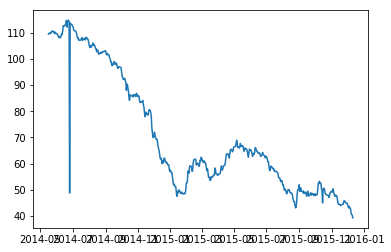

In [35]:
%matplotlib inline

# is there a time trend? Seasonal?
station1 = df[(df['station'] == 27) & (df['num_days'] > -1) & (df['num_days'] < 600)]
pyplot.plot(station1['brent'])

# should I difference by station? Yes, probably.

In [25]:
# put in order to be made into supervised problem
df.sort_values(by=['station', 'num_days'], inplace=True)
df.head()

,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,...,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean,num_days
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,15211.0,10,0,1.546131,1.561237,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622486,109.699997,101.669998,1.369580,9146.0,10,0,1.560708,1.578196,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622136,109.699997,101.669998,1.369580,9843.0,10,0,1.564237,1.581731,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.621785,109.838928,102.008537,1.370161,13502.0,10,0,1.563935,1.581525,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.620475,109.522926,102.058907,1.368282,12876.0,10,0,1.566228,1.582620,4


In [26]:
df.to_csv("supervised_1_1.csv")

In [27]:
# values = df.values
# # ensure all data is float
# values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# # frame as supervised learning
# n_lag = 1
# n_seq = 1
# reframed = series_to_supervised(scaled, n_lag, n_seq)
# # drop the values from the final day for each station
# reframed = reframed[reframed['var21(t-1)'] != 1]
# # drop columns we don't want to predict
# reframed.drop(reframed.columns[list(range(22,42))], axis=1, inplace=True)
# # reframed.drop(reframed.columns[list(range(23,43))], axis=1, inplace=True)
# reframed.head()

In [8]:
# reframed.to_csv("supervised_1_1.csv")